In [1]:
import numpy as np
import cupy as cp
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Inspect data

In [2]:
! head store/data.csv

0.233449,0.166667,0.381818,0.424594,0.164110,0.354839,0.250000,0.325581,0.166184,0.192771,6.000000
0.160279,0.196078,0.263636,0.262181,0.176380,0.161290,0.346154,0.255814,0.196453,0.301205,5.000000
0.083624,0.156863,0.300000,0.396752,0.191718,0.177419,0.355769,0.360465,0.226141,0.186747,6.000000
0.097561,0.107843,0.390909,0.201856,0.019939,0.451613,0.288462,0.372093,0.088490,0.216867,7.000000
0.073171,0.411765,0.445455,0.271462,0.007669,0.467742,0.413462,0.232558,0.128976,0.283133,5.000000
0.111498,0.235294,0.454545,0.197216,0.062883,0.822581,0.201923,0.406977,0.048775,0.168675,7.000000
0.024390,0.107843,0.309091,0.213457,0.015337,0.500000,0.442308,0.500000,0.132832,0.253012,4.000000
0.118467,0.127451,0.363636,0.262181,0.151840,0.419355,0.326923,0.209302,0.147869,0.186747,6.000000
0.108014,0.225490,0.290909,0.248260,0.185583,0.387097,0.298077,0.500000,0.159823,0.198795,6.000000
0.149826,0.137255,0.445455,0.357309,0.214724,0.096774,0.403846,0.546512,0.254290,0.253012,7.000000


## Parse data

In [3]:
import pandas as pd

df = pd.read_csv('store/data.csv', header=None)
df.columns = [ f'feat{i:1d}' for i in range(10) ] + ['label']
# df = df.convert_dtypes()
df.label = df.label.astype(int)
df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,label
0,0.233449,0.166667,0.381818,0.424594,0.164110,0.354839,0.250000,0.325581,0.166184,0.192771,6
1,0.160279,0.196078,0.263636,0.262181,0.176380,0.161290,0.346154,0.255814,0.196453,0.301205,5
2,0.083624,0.156863,0.300000,0.396752,0.191718,0.177419,0.355769,0.360465,0.226141,0.186747,6
3,0.097561,0.107843,0.390909,0.201856,0.019939,0.451613,0.288462,0.372093,0.088490,0.216867,7
4,0.073171,0.411765,0.445455,0.271462,0.007669,0.467742,0.413462,0.232558,0.128976,0.283133,5
...,...,...,...,...,...,...,...,...,...,...,...
3995,0.216028,0.098039,0.372727,0.415313,0.141104,0.419355,0.288462,0.337209,0.155966,0.144578,6
3996,0.202091,0.147059,0.400000,0.375870,0.243865,0.177419,0.317308,0.430233,0.229227,0.210843,6
3997,0.111498,0.156863,0.727273,0.278422,0.087423,0.387097,0.211538,0.220930,0.144399,0.192771,5
3998,0.052265,0.215686,0.463636,0.292343,0.058282,0.677419,0.250000,0.255814,0.103913,0.162651,6


# Train test split

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

full_x, full_y = df.drop(columns='label'), df['label']

full_x = torch.tensor(np.array(full_x)).float()
full_y = torch.tensor(np.array(full_y)).long()

train_x, val_x, train_y,  val_y = train_test_split(full_x, full_y, stratify=full_y, 
                              random_state=42, test_size=.2)

In [52]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class MLP(nn.Module):
    def __init__(self, n_feat, n_hid, n_out) -> None:
        super().__init__()
        self.norm = nn.BatchNorm1d(n_feat)
        self.ff1 = nn.Linear(n_feat, n_hid)
        self.ff2 = nn.Linear(n_hid, n_hid)
        self.out = nn.Linear(n_hid, n_out)

    def forward(self, x):
        x = self.norm(x)
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = self.out(x)
        return x
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_samp, n_feat = train_x.shape
model = MLP(n_feat, n_hid=2048, n_out=10)

loss_fn = nn.CrossEntropyLoss()
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)

train_dl = DataLoader(train_ds, 64)
val_dl = DataLoader(train_ds, 128)

def train(data, model, loss_fn, optimizer, device):
    model.train()
    for step, (X, y) in enumerate(data):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if step % 20 == 0:
            loss, current = loss.item(), (step + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{step:>5d}]")

def eval(data, model, loss_fn, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    accuracy = correct / total
    avg_loss = total_loss / len(data)
    print(f'Accuracy: {accuracy}, Average Loss: {avg_loss}')
    return accuracy


epochs = 10

perf = []
for device in ['cpu', 'cuda']:
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    print(f"Device: {device}")

    # Training
    start_time = time.time()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train(train_dl, model, loss_fn, optimizer, device=device)
        print("")
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time on {device}: {training_time} seconds")
    print("")

    # Inference
    start_time = time.time()
    eval(val_dl, model, loss_fn, device=device)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference Time on {device}: {inference_time} seconds")
    print("")

    perf.append({'Device': device, 'Training Time': training_time, 'Inference Time': inference_time})

Device: cpu
Epoch 1
-------------------------------
loss: 2.334881  [   64/    0]
loss: 0.993360  [ 1344/   20]
loss: 1.108255  [ 2624/   40]

Epoch 2
-------------------------------
loss: 1.099243  [   64/    0]
loss: 0.904090  [ 1344/   20]
loss: 1.092407  [ 2624/   40]

Epoch 3
-------------------------------
loss: 1.032120  [   64/    0]
loss: 0.886198  [ 1344/   20]
loss: 1.090690  [ 2624/   40]

Epoch 4
-------------------------------
loss: 0.999075  [   64/    0]
loss: 0.872262  [ 1344/   20]
loss: 1.071032  [ 2624/   40]

Epoch 5
-------------------------------
loss: 0.968865  [   64/    0]
loss: 0.857834  [ 1344/   20]
loss: 1.056881  [ 2624/   40]

Epoch 6
-------------------------------
loss: 0.945491  [   64/    0]
loss: 0.842943  [ 1344/   20]
loss: 1.056990  [ 2624/   40]

Epoch 7
-------------------------------
loss: 0.918751  [   64/    0]
loss: 0.818139  [ 1344/   20]
loss: 1.036024  [ 2624/   40]

Epoch 8
-------------------------------
loss: 0.896280  [   64/    0]
l

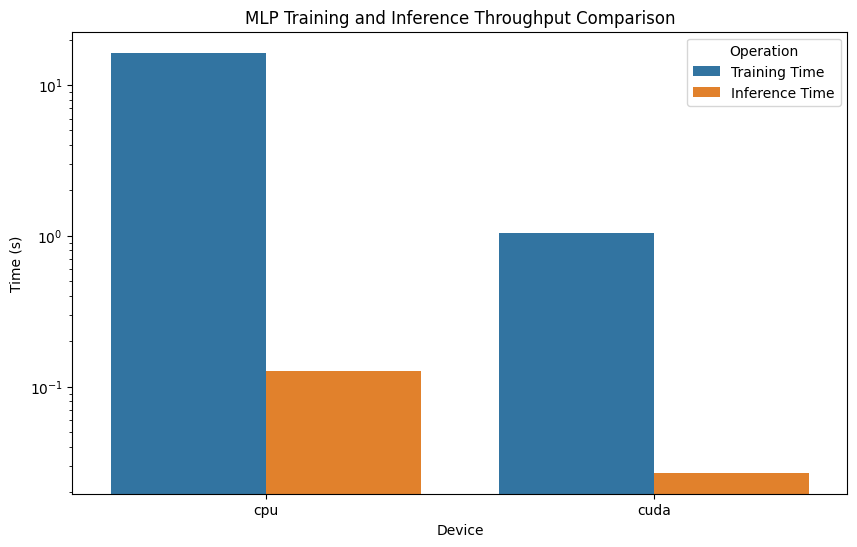

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(perf)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Device', y='Throughput', hue='Operation', data=pd.melt(df, id_vars=['Device'], 
                                                                      value_vars=['Training Time', 'Inference Time'], 
                                                                      var_name='Operation', value_name='Throughput'))
plt.title('MLP Training and Inference Throughput Comparison')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xlabel('Device')
plt.show()